### What's Cooking Kaggle challenge

In this kaggle challenge, given a set of ingredients we predict the cuisine.

#### Contents

- Analysis
- Feature Engineering
- Apply Logistic Regression
- Persist the model


We start by importing some python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
training_data = pd.read_json('./train.json')
test_data = pd.read_json('./test.json')
all_data = training_data.append(test_data)

### Analysis

We perfom some basic analysis over the training data.

##### We find the number of ingredients per dish and plot a histogram

In [3]:
training_data['separate_ingredients'] = training_data['ingredients'].apply(','.join)
min_ingredients = training_data['ingredients'].str.len().min()
max_ingredients = training_data['ingredients'].str.len().max()
print(f'Minimum number of ingredients in a dish {min_ingredients}')
print(f'Maximum number of ingredients in a dish {max_ingredients}')

Minimum number of ingredients in a dish 1
Maximum number of ingredients in a dish 65


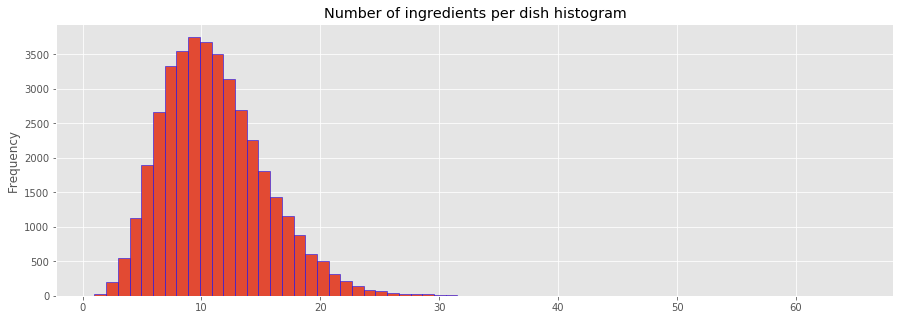

In [4]:
ingredients_histogram = {
    'title': 'Number of ingredients per dish histogram', 
    'figsize': (15, 5),
    'bins': max_ingredients,
    'edgecolor': 'b'
}
fig = training_data['ingredients'].str.len().plot.hist(**ingredients_histogram)

##### Next, We find the top 10 ingredients 

In [5]:
def plot_top15_ingredients(df, bar_title='Top 15 ingredients', bar_color='b'):
    """
    Plots the top 15 ingredients for a given dataframe
    
    :param df: dataframe containing a column with list of ingredients
    :return: None
    """
    unflaten_ingredients = df['ingredients'].tolist()
    ingredients_list = [i for each in unflaten_ingredients for i in each]
    ingredients_freq_df = pd.DataFrame({
        'count': pd.Series(ingredients_list).value_counts().values,
        'ingredients': pd.Series(ingredients_list).value_counts().index
    })
    top15_ingredients = ingredients_freq_df.head(15)
    top15_ingredients_graph = {
        'title': bar_title,
        'figsize': (15, 6),
        'edgecolor': 'w',
        'color': bar_color,
        'fontsize': 11,
    }
    fig = top15_ingredients.plot.barh(x='ingredients', **top15_ingredients_graph)

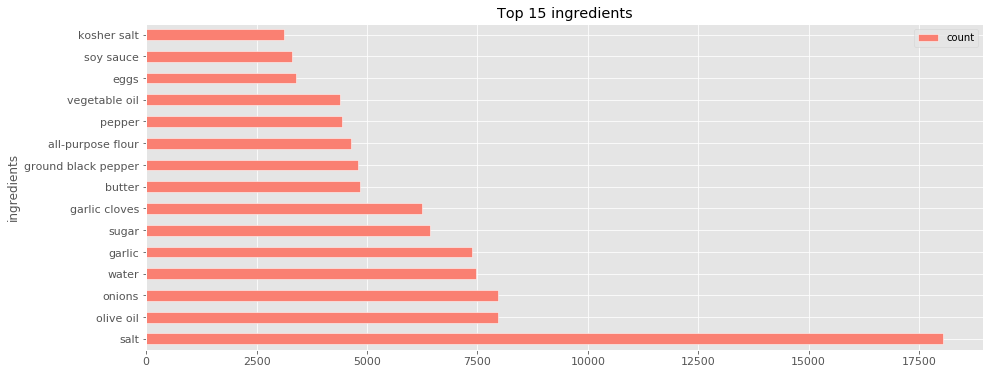

In [6]:
plot_top15_ingredients(training_data, bar_color='salmon')

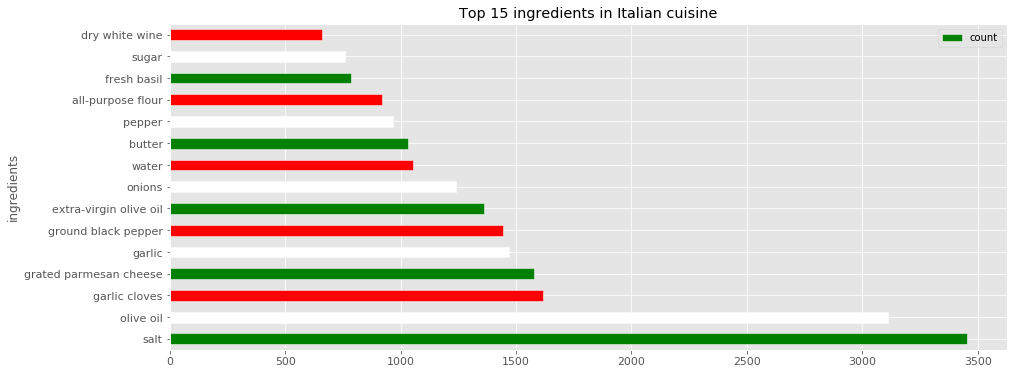

In [7]:
italian_cuisine = training_data.loc[training_data['cuisine'] == 'italian']
plot_top15_ingredients(italian_cuisine,
                       bar_title='Top 15 ingredients in Italian cuisine',
                       bar_color='gwr')

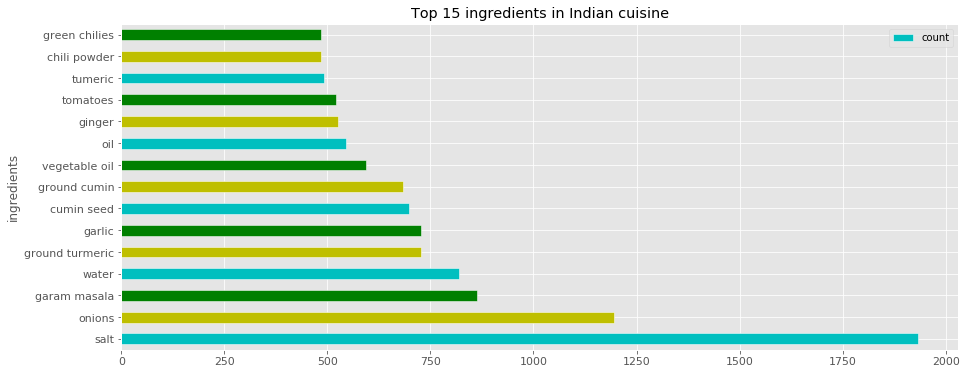

In [8]:
indian_cuisine = training_data.loc[training_data['cuisine'] == 'indian']
plot_top15_ingredients(indian_cuisine,
                       bar_title='Top 15 ingredients in Indian cuisine',
                       bar_color=['cyg'])

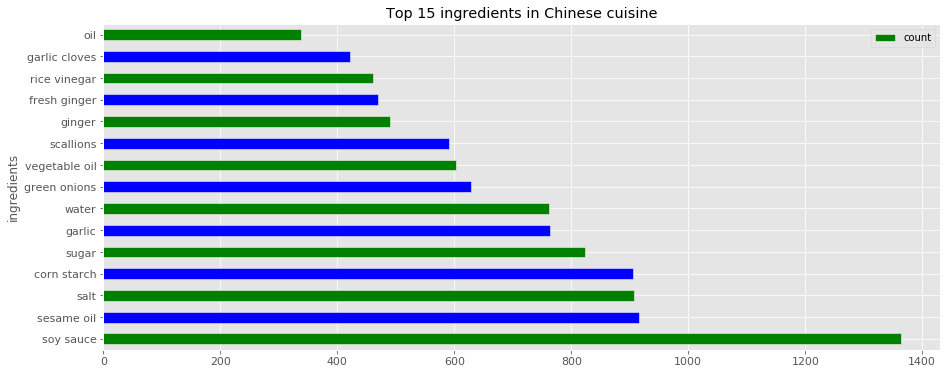

In [9]:
chinese_cuisine = training_data.loc[training_data['cuisine'] == 'chinese']
plot_top15_ingredients(chinese_cuisine,
                       bar_title='Top 15 ingredients in Chinese cuisine',
                       bar_color=['gb'])

##### Next, we see the distribution of cuisine in the training dataset

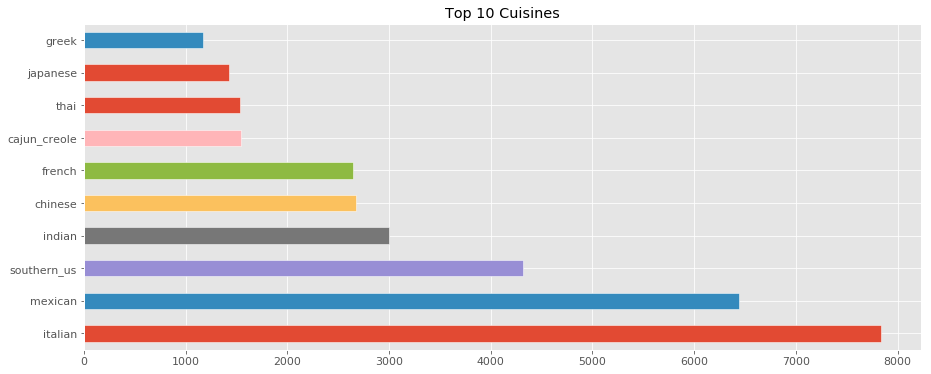

In [10]:
top10_cuisine_graph = {
        'title': 'Top 10 Cuisines',
        'figsize': (15, 6),
        'edgecolor': 'w',
        'fontsize': 11,
    }
fig = training_data['cuisine'].value_counts().head(10).plot.barh(**top10_cuisine_graph)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

# Prepare and separate train and test datasets
df_train = training_data.drop('ingredients', axis='columns')\
                        .set_index('id')\
                        .rename({'separate_ingredients': 'ingredients'}, axis='columns')

test_data.ingredients = training_data['ingredients'].apply(','.join)
df_test = test_data

/home/maddy/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Feature Engineering

The ingredients have to be converted to numeric values before feeding them to the machine learning algorithms. 

In [12]:
tfidf_vect = TfidfVectorizer(binary=True).fit(df_train['ingredients'].values)
x_train_vectorized = tfidf_vect.transform(df_train['ingredients'].values)
x_train_vectorized = x_train_vectorized.astype('float')

In [13]:
encoder = LabelEncoder().fit(df_train['cuisine'])
y_train_vectorized = encoder.transform(df_train['cuisine'])

### Logistic Regression

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_train_vectorized, y_train_vectorized, random_state=0)

In [15]:
logr = LogisticRegression(C=12, dual=False)
logr.fit(x_train, y_train)
logr.score(x_test, y_test)

0.79434835076428

In [16]:
x_test_vectorized = tfidf_vect.transform(df_test.ingredients)
predictions_vector = logr.predict(x_test_vectorized)
predictions = encoder.inverse_transform(predictions_vector)
df_pred = pd.DataFrame({'id': df_test.id, 'cuisine': predictions})
df_pred.to_csv('submission.csv', index=False)

/home/maddy/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
df_test.ingredients[0]

'romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,garbanzo beans,feta cheese crumbles'

### Persist the Model

In [17]:
from joblib import dump, load

dump(logr, 'whatscooking.joblib')
dump(tfidf_vect, 'tfidf-vectorizer.joblib')
dump(encoder, 'label-encoder.joblib')

['label-encoder.joblib']

#### References

1. https://www.kaggle.com/ash316/what-is-the-rock-cooking-ensembling-network
2. https://www.youtube.com/watch?v=RZYjsw6P4nI